# Read data

In [1]:
import pandas as pd
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre_path = r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_2000_inter100.txt"
obl_path = r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_2000_inter100.txt"
df_pre_raw = pd.read_csv(pre_path, sep=r'\s+', header=None, engine='python')
df_obl_raw = pd.read_csv(obl_path, sep=r'\s+', header=None, engine='python')

# convert to years & ensure age increasing
df_pre_raw.iloc[:,0] = df_pre_raw.iloc[:,0].abs() * 1000
df_obl_raw.iloc[:,0] = df_obl_raw.iloc[:,0].abs() * 1000
df_pre_raw = df_pre_raw.iloc[::-1].reset_index(drop=True)
df_obl_raw = df_obl_raw.iloc[::-1].reset_index(drop=True)
df_pre_raw.columns = ['age','pre']
df_obl_raw.columns = ['age','obl']

ecc_path = r"D:\VScode\bipolar_seesaw_CCM\inso_data\ecc_1000_inter100.txt"

df_ecc_raw = pd.read_csv(ecc_path, sep=r'\s+', header=None, engine='python')

# convert to years & ensure age increasing
df_ecc_raw.iloc[:,0] = df_ecc_raw.iloc[:,0].abs() * 1000
df_ecc_raw = df_ecc_raw.iloc[::-1].reset_index(drop=True)
df_ecc_raw.columns = ['age','ecc']



# read the filtered data
df_filt_ch4 = pd.read_csv('D:/VScode/bipolar_seesaw_CCM/filtered_data/CH4_AICC2023_filtered.csv')
df_filt_d18O = pd.read_csv('D:/VScode/bipolar_seesaw_CCM/filtered_data/Speleothem_d18O_filtered.csv')


#read the filtered d18O data
# df_filt_d18O_B = pd.read_csv(r'D:\VScode\bipolar_seesaw_CCM\filtered_data\MD01-2444_339-U1385_benthic_d18O_hp_filt.csv')
df_filt_d18O_B = pd.read_csv(r'D:\VScode\bipolar_seesaw_CCM\filtered_data\MD01-2444_339-U1385_plank_d18O_hp_filt.csv')


df_filt_ch4 = sa.interpolate_df(df_filt_ch4, 50)
df_filt_d18O = sa.interpolate_df(df_filt_d18O, 50)
df_filt_d18O_B = sa.interpolate_df(df_filt_d18O_B, 50)


df_filt_d18O['filt_d18O']= df_filt_d18O['filt_d18O']*-1
# apply 5 pt moving average to smooth the df_filt_d18O, remove nan
df_filt_d18O['filt_d18O'] = df_filt_d18O['filt_d18O'].rolling(window=5, center=True).mean()
# remove NaN values from the smoothed column
df_filt_d18O = df_filt_d18O.dropna(subset=['filt_d18O'])

df_filt_d18O_B['filt_d18O'] = df_filt_d18O_B['filt_d18O'].rolling(window=5, center=True).mean()
# remove NaN values from the smoothed column
df_filt_d18O_B = df_filt_d18O_B.dropna(subset=['filt_d18O'])


# load the saved csv files
df_ch4_raw = pd.read_csv('D:/VScode/bipolar_seesaw_CCM/Raw_data/CH4_AICC2023.csv')
df_d18O_raw = pd.read_csv('D:/VScode/bipolar_seesaw_CCM/Raw_data/Speleothem_d18O.csv')
# df_d18O_B_raw = pd.read_csv(r'D:\VScode\bipolar_seesaw_CCM\Raw_data\MD01-2444_339-U1385_benthic_d18O.csv')
df_d18O_B_raw = pd.read_csv(r'D:\VScode\bipolar_seesaw_CCM\Raw_data\MD01-2444_339-U1385_plank_d18O.csv')

df_d18O_raw['-d18O'] = df_d18O_raw['-d18O'] * -1

# # print the information of the dataframes
# print(df_pre_raw.info())
# print(df_obl_raw.info())
# print(df_ecc_raw.info())
# print(df_filt_ch4.info())
# print(df_filt_d18O.info())
# print(df_filt_d18O_B.info())
# print(df_ch4_raw.info())
# print(df_d18O_raw.info())
# print(df_d18O_B_raw.info())

# print the max and min of áge'column in all raw data

print("Max age in df_ch4_raw:", df_ch4_raw['age'].max())
print("Min age in df_ch4_raw:", df_ch4_raw['age'].min())
print("Max age in df_d18O_raw:", df_d18O_raw['age'].max())
print("Min age in df_d18O_raw:", df_d18O_raw['age'].min())
print("Max age in df_d18O_B_raw:", df_d18O_B_raw['age'].max())



Max age in df_ch4_raw: 799638.323636364
Min age in df_ch4_raw: -66.0
Max age in df_d18O_raw: 641264.4
Min age in df_d18O_raw: -16.501
Max age in df_d18O_B_raw: 649550.0


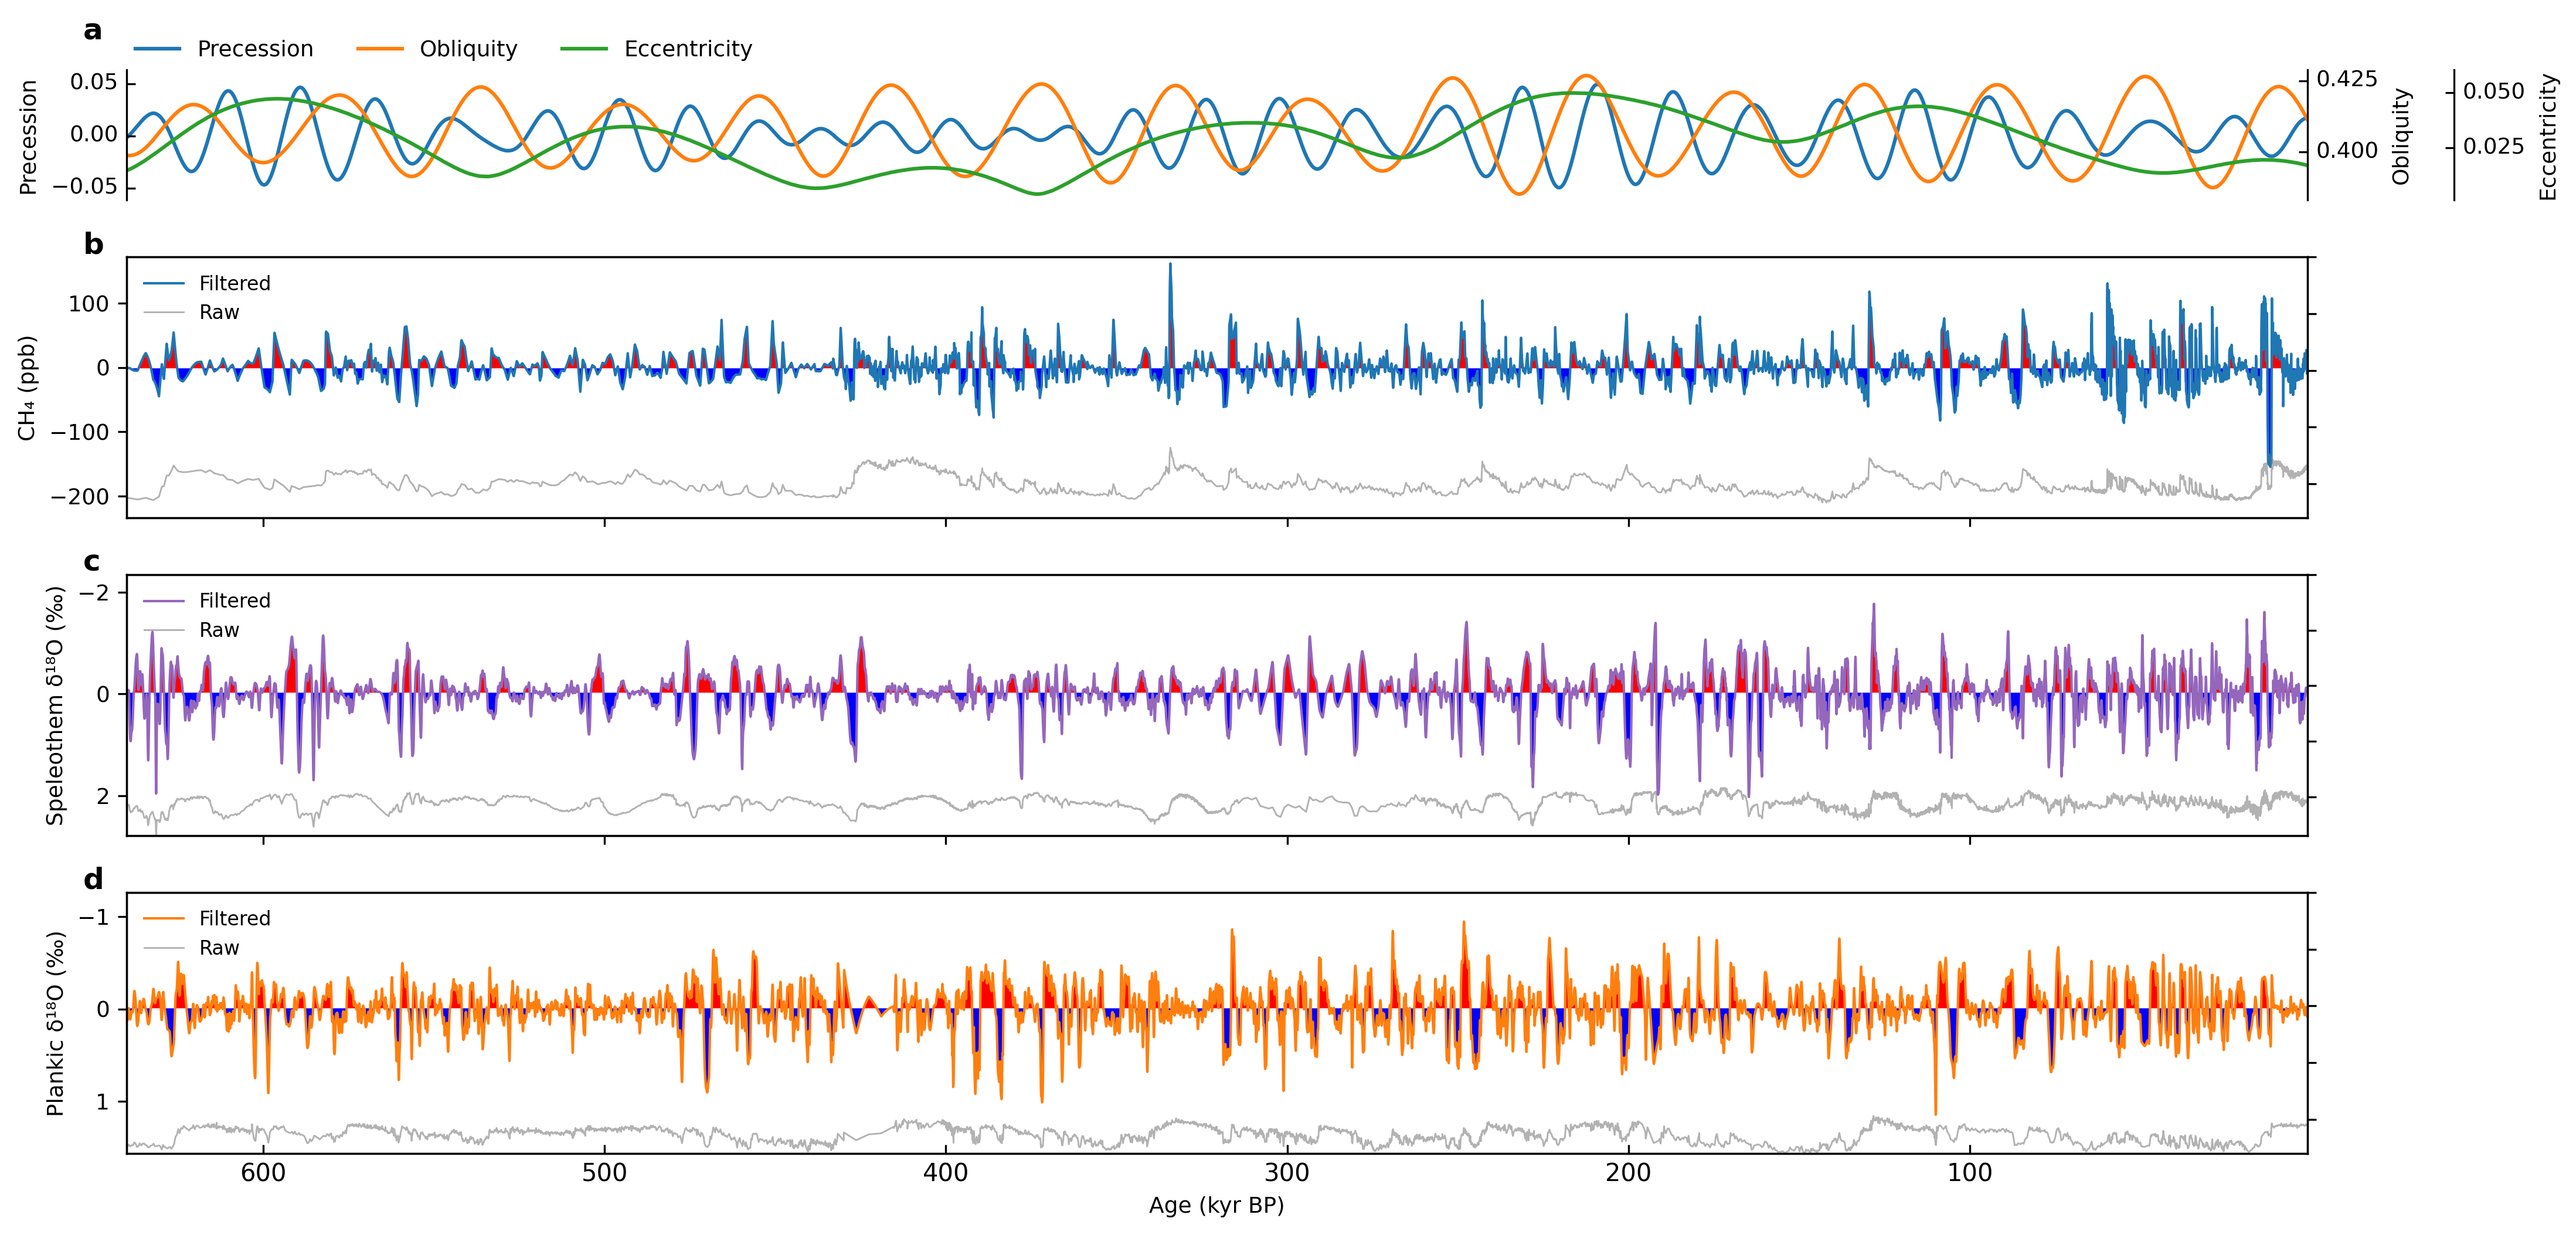

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np
import pandas as pd

# ----------------------------------------------------------------
# Utility: coloured fill above / below median
# ----------------------------------------------------------------
def fill_above_below(ax, x, y, median,
                     warm='red', cold='blue',
                     invert_logic=False):
    """
    Shade areas above (warm) and below (cold) a reference (median).

    invert_logic=True swaps the “above / below” test for inverted axes.
    """
    if invert_logic:
        warm_cond = y < median
        cold_cond = y > median
    else:
        warm_cond = y > median
        cold_cond = y < median

    ax.fill_between(x, y, median, where=warm_cond, interpolate=True,
                    color=warm, alpha=1, lw=0)
    ax.fill_between(x, y, median, where=cold_cond, interpolate=True,
                    color=cold, alpha=1, lw=0)

# ----------------------------------------------------------------
# Figure & gridspec  (first row shorter)
# ----------------------------------------------------------------
fig = plt.figure(figsize=(16, 8), dpi=300)
gs  = fig.add_gridspec(4, 1, height_ratios=[2, 4, 4, 4],
                       hspace=0.25)

# ----------------------------------------------------------------
# Row 1 – orbital parameters with three y-axes
# ----------------------------------------------------------------
host = host_subplot(gs[0], axes_class=AA.Axes)   # main axis
fig.add_subplot(host)

par1 = host.twinx()                              # 2nd y-axis (right)
par2 = host.twinx()                              # 3rd y-axis (far right)
par1.axis['right'].toggle(all=True)

par2.axis['right'] = par2.new_fixed_axis(loc='right', offset=(60, 0))
par2.axis['right'].toggle(all=True)

l1, = host.plot(df_pre_raw['age'], df_pre_raw['pre'],
                color='tab:blue',   label='Precession')
l2, = par1.plot(df_obl_raw['age'], df_obl_raw['obl'],
                color='tab:orange', label='Obliquity')
l3, = par2.plot(df_ecc_raw['age'], df_ecc_raw['ecc'],
                color='tab:green',  label='Eccentricity')

host.set_ylabel('Precession')
par1.set_ylabel('Obliquity')    # ensure label shows
par2.set_ylabel('Eccentricity', labelpad=75)
# add a panel label
host.text(-0.02, 1.4, 'a', transform=host.transAxes,
          fontsize=12, fontweight='bold', va='top', ha='left')

# shared x-axis (oldest on left)
host.set_xlim(640_000, 1_000)
# host.invert_xaxis()

# # Remove top/bottom spines & hide x-axis for ALL three y-axes
# for ax_ in (host, par1, par2):
#     for sp in ('top', 'bottom'):
#         ax_.spines[sp].set_visible(False)
#     ax_.get_xaxis().set_visible(False)


for ax_ in (host, par1, par2):
    # turn off the axisartist lines
    ax_.axis['top'   ].set_visible(False)
    ax_.axis['bottom'].set_visible(False)

    # (optional) also hide ticks & tick-labels that live on those axes
    ax_.axis['top'   ].major_ticks.set_visible(False)
    ax_.axis['bottom'].major_ticks.set_visible(False)
    ax_.axis['top'   ].major_ticklabels.set_visible(False)
    ax_.axis['bottom'].major_ticklabels.set_visible(False)



host.legend([l1, l2, l3],
            ['Precession', 'Obliquity', 'Eccentricity'],
            loc=[0, 1], frameon=False, fontsize=9, ncol=3)


# ----------------------------------------------------------------
# Helper: proxy row with separate y-axes
# ----------------------------------------------------------------
def proxy_row(ax, age_filt, filt, age_raw, raw,
              filt_label, raw_label,
              filt_color='k', raw_color='tab:grey',y_lim_raw=(-50, 50),
              invert=False, panel_label=''):
    """
    Plot filtered data on left y-axis, raw data on right y-axis,
    shade relative to median, and optionally invert both axes.
    """
    # Filtered curve (left axis)
    ax.plot(age_filt, filt, color=filt_color, lw=1.0, label='Filtered')
    ax.set_ylabel(filt_label)
    if panel_label:
        ax.text(-0.02, 1.1, panel_label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left')

    # Shading
    med = np.nanmedian(filt)
    fill_above_below(ax, age_filt, filt, med,
                     warm='red', cold='blue',
                     invert_logic=invert)

    # Raw curve on its own twin y-axis
    ax_raw = ax.twinx()
    ax_raw.plot(age_raw, raw, color=raw_color, lw=0.7, alpha=0.6,
                label='Raw')
    # set y_lim of ax_raw
    ax_raw.set_ylim(y_lim_raw[0], y_lim_raw[1])
    ax_raw.set_ylabel(raw_label)
    ax_raw.tick_params(axis='y', labelright=True)
    # turn off y-ticks of ax_raw


    # set y-tick labels of ax_raw to empty
    ax_raw.set_yticklabels([])



    if invert:
        ax_raw.invert_yaxis()     # keep orientation consistent

    # Invert left axis if requested
    if invert:
        
        # set y_lim of ax
        ax.set_ylim(np.nanmin(filt)-0.15*(np.nanmax(filt)-np.nanmin(filt)), np.nanmax(filt)+0.2*(np.nanmax(filt)-np.nanmin(filt)))
        ax.invert_yaxis()

    else:
        ax.set_ylim(np.nanmin(filt)-0.25*(np.nanmax(filt)-np.nanmin(filt)), np.nanmax(filt)+10)


    # Legend (Filtered / Raw)
    ax.legend(handles=[ax.lines[0], ax_raw.lines[0]],
              labels=['Filtered', 'Raw'],
              loc='upper left',
               frameon=False, fontsize=8)

    # shared x
    ax.set_xlim(640_000, 1_000)

# ----------------------------------------------------------------
# Row 2 – CH₄
# ----------------------------------------------------------------
ax2 = fig.add_subplot(gs[1], sharex=host)
proxy_row(ax2,
          df_filt_ch4['age'],  df_filt_ch4['filt_ch4'],
          df_ch4_raw['age'],   df_ch4_raw['ch4'],
          'CH₄ (ppb)', '',
          filt_color='tab:blue', invert=False, y_lim_raw=[200, 2500], panel_label='b')

# ----------------------------------------------------------------
# Row 3 – Speleothem δ18O  (inverted y)
# ----------------------------------------------------------------
ax3 = fig.add_subplot(gs[2], sharex=host)
proxy_row(ax3,
          df_filt_d18O['age'], df_filt_d18O['filt_d18O'],
          df_d18O_raw['age'],  df_d18O_raw['-d18O'],
          'Speleothem δ¹⁸O (‰)', '',
          filt_color='tab:purple', invert=True,  y_lim_raw=[-50, -3], panel_label='c')

# ----------------------------------------------------------------
# Row 4 – Plankic δ18O  (inverted y)
# ----------------------------------------------------------------
ax4 = fig.add_subplot(gs[3], sharex=host)
proxy_row(ax4,
          df_filt_d18O_B['age'], df_filt_d18O_B['filt_d18O'],
          df_d18O_B_raw['age'],  df_d18O_B_raw['d18O'],
          'Plankic δ¹⁸O (‰)', '',
          filt_color='tab:orange', invert=True,  y_lim_raw=[-20, 3], panel_label='d')

# Show x-tick labels only on bottom panel
for ax in (ax2, ax3):
    ax.tick_params(axis='x', which='both', labelbottom=False)


# let the xtick lable to be tick value/1000
ax4.set_xticks(np.arange(0, 650_000, 100_000))
ax4.set_xticklabels(np.arange(0, 650, 100), fontsize=10)
ax4.set_xlim(640_000, 1_000)

ax4.set_xlabel('Age (kyr BP)')
ax4.tick_params(axis='x', which='both', direction='in')

# ----------------------------------------------------------------
# Display / save
# ----------------------------------------------------------------
plt.show()
# fig.savefig('orbital_proxies_four_panel.png', dpi=300)


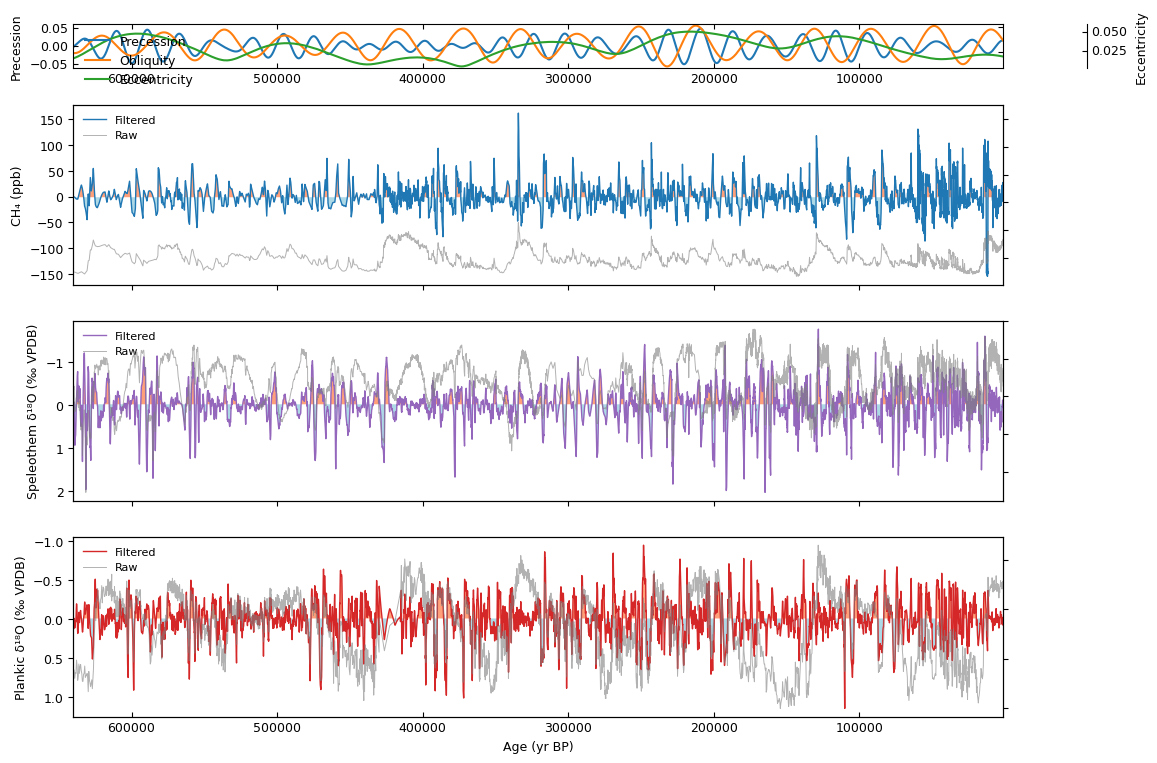

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np
import pandas as pd


def fill_above_below(ax, x, y, median, warm='lightsalmon', cold='lightblue',
                     invert_logic=False):
    """
    Shade areas above and below the median.
    Parameters
    ----------
    invert_logic : bool
        If True, swap warm/cold logic (used when y-axis is inverted).
    """
    if invert_logic:
        warm_cond = y < median      # lower values look 'higher' on an inverted axis
        cold_cond = y > median
    else:
        warm_cond = y > median
        cold_cond = y < median

    ax.fill_between(x, y, median, where=warm_cond, interpolate=True,
                    color=warm, alpha=1, linewidth=0)
    ax.fill_between(x, y, median, where=cold_cond, interpolate=True,
                    color=cold, alpha=1, linewidth=0)

# -----------------------------------------------------------------
# 1.  Figure & gridspec (first row short)
# -----------------------------------------------------------------
fig = plt.figure(figsize=(12, 9))
gs  = fig.add_gridspec(4, 1, height_ratios=[1, 4, 4, 4], hspace=0.25)

# -----------------------------------------------------------------
# 2.  Row 1 : three orbital parameters, three y-axes
# -----------------------------------------------------------------
host = host_subplot(gs[0], axes_class=AA.Axes)
fig.add_subplot(host)

par1 = host.twinx()                         # right y-axis
par2 = host.twinx()                         # far-right y-axis
par2.axis['right'] = par2.new_fixed_axis(loc='right', offset=(60, 0))
par2.axis['right'].toggle(all=True)

l1, = host.plot(df_pre_raw['age'], df_pre_raw['pre'],
                color='tab:blue',   label='Precession')
l2, = par1 .plot(df_obl_raw['age'], df_obl_raw['obl'],
                color='tab:orange', label='Obliquity')
l3, = par2 .plot(df_ecc_raw['age'], df_ecc_raw['ecc'],
                color='tab:green',  label='Eccentricity')

# Y-labels (manually padded to avoid overlap)
host.set_ylabel('Precession')
par1.set_ylabel('Obliquity',  labelpad=35)
par2.set_ylabel('Eccentricity', labelpad=75)

# Shared x-axis range, oldest on left
host.set_xlim(640_000, 1_000)
host.invert_xaxis()

# Remove spines & x-axis (shares x with proxies)
for spine in ('top', 'bottom'):
    host.spines[spine].set_visible(False)
host.get_xaxis().set_visible(False)

# Legend
host.legend([l1, l2, l3], ['Precession', 'Obliquity', 'Eccentricity'],
            loc='upper left', frameon=False, fontsize=9)

# -----------------------------------------------------------------
# 3.  Helper for proxy rows
# -----------------------------------------------------------------
def proxy_row(ax, age_filt, filt, age_raw, raw, label,
              filt_color='k', raw_color='tab:grey', invert=False):
    """
    Plot filtered (main axis) & raw (own twin axis) curves,
    reverse y-axis if `invert`, and shade warm/cold vs median.
    """
    # Main (filtered) line
    ax.plot(age_filt, filt, color=filt_color, lw=1.0, label='Filtered')
    ax.set_ylabel(label)

    # Shading relative to the median
    med = np.nanmedian(filt)
    fill_above_below(ax, age_filt, filt, med,
                     warm='lightsalmon', cold='lightblue',
                     invert_logic=invert)

    # Twin y-axis for raw data
    ax_raw = ax.twinx()
    ax_raw.plot(age_raw, raw, color=raw_color, lw=0.7, alpha=0.6,
                label='Raw')
    ax_raw.tick_params(axis='y', labelright=False)
    if invert:          # keep raw axis orientation consistent with main axis
        ax_raw.invert_yaxis()

    # Optionally invert the main y-axis
    if invert:
        ax.invert_yaxis()

    # Two-entry legend
    ax.legend(handles=[ax.lines[0], ax_raw.lines[0]],
              labels=['Filtered', 'Raw'],
              loc='upper left', frameon=False, fontsize=8)

    # Shared x
    ax.set_xlim(640_000, 1_000)
    # ax.invert_xaxis()

# -----------------------------------------------------------------
# 4.  Row 2 – CH₄
# -----------------------------------------------------------------
ax2 = fig.add_subplot(gs[1], sharex=host)
proxy_row(ax2,
          df_filt_ch4['age'],  df_filt_ch4['filt_ch4'],
          df_ch4_raw['age'],   df_ch4_raw['ch4'],
          'CH₄ (ppb)',
          filt_color='tab:blue',
          invert=False)

# -----------------------------------------------------------------
# 5.  Row 3 – Speleothem δ¹⁸O (invert y)
# -----------------------------------------------------------------
ax3 = fig.add_subplot(gs[2], sharex=host)
proxy_row(ax3,
          df_filt_d18O['age'], df_filt_d18O['filt_d18O'],
          df_d18O_raw['age'],  df_d18O_raw['-d18O'],
          'Speleothem δ¹⁸O (‰ VPDB)',
          filt_color='tab:purple',
          invert=True)

# -----------------------------------------------------------------
# 6.  Row 4 – Plankic δ¹⁸O (invert y)
# -----------------------------------------------------------------
ax4 = fig.add_subplot(gs[3], sharex=host)
proxy_row(ax4,
          df_filt_d18O_B['age'], df_filt_d18O_B['filt_d18O'],
          df_d18O_B_raw['age'],  df_d18O_B_raw['d18O'],
          'Plankic δ¹⁸O (‰ VPDB)',
          filt_color='tab:red',
          invert=True)

# Show x-tick labels only on the last row
for ax in (ax2, ax3):
    ax.tick_params(axis='x', which='both', labelbottom=False)
ax4.set_xlabel('Age (yr BP)')
ax4.tick_params(axis='x', which='both', direction='in')

# -----------------------------------------------------------------
# 7.  Display / save
# -----------------------------------------------------------------
# (tight_layout() removed per request; spacing handled via gridspec hspace)
plt.show()
# fig.savefig('orbital_proxies_four_panel.png', dpi=300)


C:\Users\zps19\AppData\Local\Temp\ipykernel_61640\3218434570.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


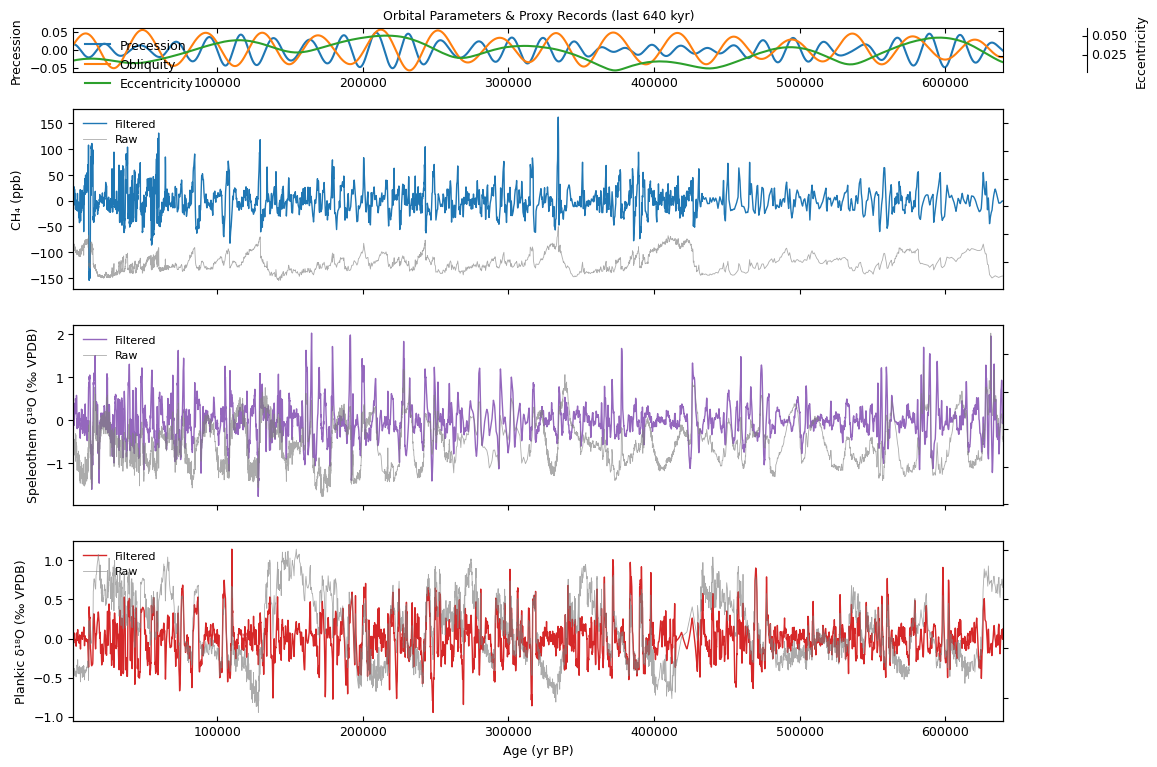

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import pandas as pd

# ── assume the nine data frames already exist ────────────────────────────
# df_pre_raw, df_obl_raw, df_ecc_raw,
# df_filt_ch4, df_filt_d18O, df_filt_d18O_B,
# df_ch4_raw, df_d18O_raw, df_d18O_B_raw
# ─────────────────────────────────────────────────────────────────────────

# -----------------------------------------------------------------------
# 1.  Figure & gridspec  (first row ¼ the height of a proxy row)
# -----------------------------------------------------------------------
fig = plt.figure(figsize=(12, 9))
gs  = fig.add_gridspec(nrows=4, ncols=1,
                       height_ratios=[1, 4, 4, 4],   # row-1 shorter
                       hspace=0.25)

# -----------------------------------------------------------------------
# 2.  Row 1 : three orbital parameters, three y-axes
# -----------------------------------------------------------------------
host = host_subplot(gs[0], axes_class=AA.Axes)
fig.add_subplot(host)

par1 = host.twinx()                   # 2nd y-axis (right)
par2 = host.twinx()                   # 3rd y-axis (further right)
par2.axis['right'] = par2.new_fixed_axis(loc='right', offset=(60, 0))
par2.axis['right'].toggle(all=True)

l1, = host.plot(df_pre_raw['age'], df_pre_raw['pre'],
                color='tab:blue',   label='Precession')
l2, = par1 .plot(df_obl_raw['age'], df_obl_raw['obl'],
                color='tab:orange', label='Obliquity')
l3, = par2 .plot(df_ecc_raw['age'], df_ecc_raw['ecc'],
                color='tab:green',  label='Eccentricity')

host.set_ylabel('Precession')
par1.set_ylabel('Obliquity')
par2.set_ylabel('Eccentricity')
host.set_xlim(640_000, 1_000)
host.invert_xaxis()
host.set_title('Orbital Parameters & Proxy Records (last 640 kyr)')
host.legend([l1, l2, l3], ['Precession', 'Obliquity', 'Eccentricity'],
            loc='upper left', frameon=False, fontsize=9)

# -----------------------------------------------------------------------
# helper for proxy rows
# -----------------------------------------------------------------------
def proxy_row(ax, age_filt, filt, age_raw, raw, label,
              filt_color='k', raw_color='tab:grey'):
    """Plot filtered (main y) and raw (separate twin-y) curves."""
    ax.plot(age_filt, filt, color=filt_color, lw=1.0, label='Filtered')
    ax.set_ylabel(label)

    # twin y-axis for raw data
    ax_raw = ax.twinx()
    ax_raw.plot(age_raw, raw, color=raw_color, lw=0.6, alpha=0.65,
                label='Raw')
    ax_raw.tick_params(axis='y', labelright=False)  # hide raw tick labels

    # add a compact 2-entry legend
    ax.legend(handles=[ax.lines[0], ax_raw.lines[0]],
              labels=['Filtered', 'Raw'],
              loc='upper left', frameon=False, fontsize=8)

    ax.set_xlim(640_000, 1_000)
    ax.invert_xaxis()

# -----------------------------------------------------------------------
# 3.  Row 2 – CH₄
# -----------------------------------------------------------------------
ax2 = fig.add_subplot(gs[1], sharex=host)
proxy_row(ax2,
          df_filt_ch4['age'],  df_filt_ch4['filt_ch4'],
          df_ch4_raw['age'],   df_ch4_raw['ch4'],
          'CH₄ (ppb)',
          filt_color='tab:blue')

# -----------------------------------------------------------------------
# 4.  Row 3 – Speleothem δ¹⁸O
# -----------------------------------------------------------------------
ax3 = fig.add_subplot(gs[2], sharex=host)
proxy_row(ax3,
          df_filt_d18O['age'], df_filt_d18O['filt_d18O'],
          df_d18O_raw['age'],  df_d18O_raw['-d18O'],
          'Speleothem δ¹⁸O (‰ VPDB)',
          filt_color='tab:purple')

# -----------------------------------------------------------------------
# 5.  Row 4 – Plankic δ¹⁸O
# -----------------------------------------------------------------------
ax4 = fig.add_subplot(gs[3], sharex=host)
proxy_row(ax4,
          df_filt_d18O_B['age'], df_filt_d18O_B['filt_d18O'],
          df_d18O_B_raw['age'],  df_d18O_B_raw['d18O'],
          'Plankic δ¹⁸O (‰ VPDB)',
          filt_color='tab:red')

# Show x-tick labels only on the last row
for ax in (ax2, ax3):
    ax.tick_params(axis='x', which='both', labelbottom=False)

ax4.set_xlabel('Age (yr BP)')
ax4.tick_params(axis='x', which='both', direction='in')

plt.tight_layout()
plt.show()
# fig.savefig('orbital_proxies_four_panel.png', dpi=300)


C:\Users\zps19\AppData\Local\Temp\ipykernel_61640\3453498942.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


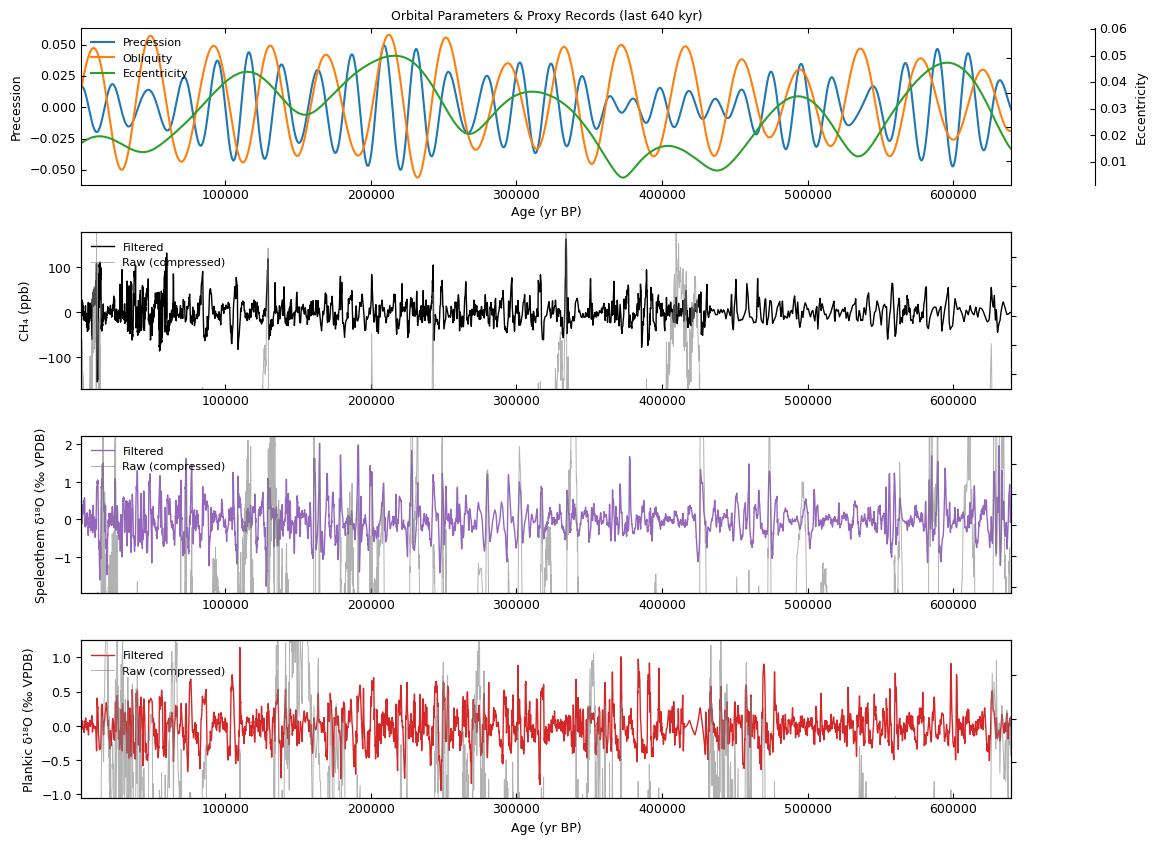

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import pandas as pd
import numpy as np


# -----------------------------------------------------------------
# 1.  Figure & gridspec
# -----------------------------------------------------------------
fig = plt.figure(figsize=(12, 10))
gs  = fig.add_gridspec(4, 1, hspace=0.30)

# -----------------------------------------------------------------
# 2.  Row 1 : three orbital parameters on three y-axes
# -----------------------------------------------------------------
host = host_subplot(gs[0, 0], axes_class=AA.Axes)        # main axis
fig.add_subplot(host)

par1 = host.twinx()                                      # 2nd y-axis
par2 = host.twinx()                                      # 3rd y-axis
# Offset the 3rd axis so its spine does not overlap the 2nd
par2.axis['right'] = par2.new_fixed_axis(loc='right', offset=(60, 0))
par2.axis['right'].toggle(all=True)

# Plot
l1, = host.plot(df_pre_raw['age'], df_pre_raw['pre'],
                color='tab:blue',  label='Precession')
l2, = par1.plot(df_obl_raw['age'], df_obl_raw['obl'],
                color='tab:orange',label='Obliquity')
l3, = par2.plot(df_ecc_raw['age'], df_ecc_raw['ecc'],
                color='tab:green', label='Eccentricity')

# Axis formatting
host.set_ylabel('Precession')
par1.set_ylabel('Obliquity')
par2.set_ylabel('Eccentricity')
host.set_title('Orbital Parameters & Proxy Records (last 640 kyr)')
host.set_xlim(640_000, 1_000)          # larger age on the left
host.invert_xaxis()                    # just to be safe
host.set_xlabel('Age (yr BP)')         # appears only once—overwritten later

# Put a combined legend on the left
lns = [l1, l2, l3]
host.legend(lns, [l.get_label() for l in lns], loc='upper left', frameon=False)

# -----------------------------------------------------------------
# Helper:  proxy-row plotting routine
# -----------------------------------------------------------------
def plot_proxy(ax, age_filt, filt, age_raw, raw, ylab,
               filt_color='k', raw_color='tab:grey'):
    """Plot filtered series on main y-axis and raw series on a compressed twin axis."""
    # main line (filtered)
    ax.plot(age_filt, filt, color=filt_color, lw=1, label='Filtered')

    # twin y-axis for raw data (shorter span)
    ax_raw = ax.twinx()
    ax_raw.plot(age_raw, raw, color=raw_color, lw=0.7, alpha=0.6,
                label='Raw (compressed)')
    # compress raw-axis so the line hugs the top 25 %
    lo, hi = np.nanpercentile(raw, [2, 98])
    span = hi - lo
    ax_raw.set_ylim(lo + 0.75*span, lo + 1.05*span)   # adjust as desired
    ax_raw.tick_params(axis='y', labelright=False)     # hide labels
    ax.set_ylabel(ylab)
    ax.set_xlim(640_000, 1_000)
    ax.invert_xaxis()
    # Show only one legend entry per row (filtered v raw)
    lines = ax.get_lines() + ax_raw.get_lines()
    ax.legend(lines, [l.get_label() for l in lines], loc='upper left',
              frameon=False, fontsize=8)

# -----------------------------------------------------------------
# 3.  Row 2 – CH4
# -----------------------------------------------------------------
ax2 = fig.add_subplot(gs[1, 0], sharex=host)
plot_proxy(ax2,
           df_filt_ch4['age'],  df_filt_ch4['filt_ch4'],
           df_ch4_raw['age'],   df_ch4_raw['ch4'],
           'CH₄ (ppb)')

# -----------------------------------------------------------------
# 4.  Row 3 – Speleothem δ18O
# -----------------------------------------------------------------
ax3 = fig.add_subplot(gs[2, 0], sharex=host)
plot_proxy(ax3,
           df_filt_d18O['age'], df_filt_d18O['filt_d18O'],
           df_d18O_raw['age'],  df_d18O_raw['-d18O'],
           'Speleothem δ¹⁸O (‰ VPDB)',
           filt_color='tab:purple')

# -----------------------------------------------------------------
# 5.  Row 4 – Plankic δ18O
# -----------------------------------------------------------------
ax4 = fig.add_subplot(gs[3, 0], sharex=host)
plot_proxy(ax4,
           df_filt_d18O_B['age'], df_filt_d18O_B['filt_d18O'],
           df_d18O_B_raw['age'],  df_d18O_B_raw['d18O'],
           'Plankic δ¹⁸O (‰ VPDB)',
           filt_color='tab:red')

# Label the common x-axis only on the bottom row
ax4.set_xlabel('Age (yr BP)')

# -----------------------------------------------------------------
# 6.  Final tidy-up and show / save
# -----------------------------------------------------------------
for ax in (ax2, ax3, ax4):
    ax.tick_params(axis='x', which='both', direction='in')

plt.tight_layout()
plt.show()
# Optional:  fig.savefig('orbital_proxies_4panel.png', dpi=300)
